In [40]:
"""
Expects a csv file with parcel id, maxlat, maxlon, minlat, minlon of each satellite image
Expects a json file with the polygons parsed from the shapefile 

Run python utils/create_mask.py [csv_file_path] [json_file_path]
"""

import json
import numpy as np
import sys
import cv2
import csv
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict 

In [41]:

def read_csv(csv_file):
  grid = dict()
  keys = ['maxlat', 'maxlon', 'minlat', 'minlon']
  with open(csv_file) as f:
    readCSV = csv.reader(f)
    for index, row in enumerate(readCSV, -1):
      if index == -1:
        continue
      if index not in grid:
        grid[index] = dict()
        for key in keys:
          grid[index][key] = 0
      grid[index]['Image_id'] = float(row[0])  #SENTINEL
      

      # Sentinel
      grid[index]['maxlat'] = float(row[1])
      grid[index]['maxlon'] = float(row[2])
      grid[index]['minlat'] = float(row[3])
      grid[index]['minlon'] = float(row[4])
      
  return grid

def point_is_in_bounds(point, w, h):
  if point[0] >= 0 and points[0] > w and point[1] >= 0 and point[1] <= h:
    return True
  return False

def create_empty_masks(grid, shape_size):
    for index in range(len(grid.keys())):
        image_id = grid[index]['Image_id']
        mask = np.zeros(shape_size)
        cv2.imwrite(base_dir + 'masks/image_binary_' + str(int(image_id)) + '.png', np.array(mask))
        cv2.imwrite(base_dir + 'masks_filled/image_filled_binary_' + str(int(image_id)) + '.png', np.array(mask))
        
        im_name = base_dir + orig_images_dir + str(int(image_id)) +'.jpeg'
        orig_image = cv2.imread(im_name)
        overlay_path = base_dir + 'overlay/image_overlay_' + str(int(image_id)) + '.jpeg'
        cv2.imwrite(overlay_path, orig_image)
        
def scale_coords(shape_size, geom, grid, index, size_m = 450):
  w, h = shape_size
  min_lat, min_lon, max_lat, max_lon = grid[index]['minlat'], grid[index]['minlon'], grid[index]['maxlat'], grid[index]['maxlon']
  x = geom[:,0]
  y = geom[:,1]
  scale_lon = w/(max_lon - min_lon)
  scale_lat = h/(max_lat-min_lat)
  scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
  scaled_y = h - ((y - min_lat) * scale_lat)
  if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
     return False, np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
  return True, np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

def create_dict_parcels(grid, shp_dict):
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['IMAGE_ID']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

base_dir = 'data/sentinel/'
csv_file = 'data/img_csv.csv'
json_folder = ['data/pyshp-all-2000-sentinel-new-jsonfinal_overlapping4boxes86254.json']
# x = os.listdir('/data/sentinel_tf/json_polys')
# json_folder = [base_dir + 'json_polys/' + f for f in os.listdir(base_dir + 'json_polys/')]
orig_images_dir = 'inel_tf/Land_parcels_france_Sentinel2_3mo_comp_s2_median_fr_apr_jun_ee_export/'
num_json_files_parsed = 0
num_fields_parsed = 0

if os.path.exists(base_dir + 'masks/') == False:
    os.makedirs(base_dir + 'masks/')
if os.path.exists(base_dir + 'masks_filled/') == False:
    os.makedirs(base_dir + 'masks_filled/')
if os.path.exists(base_dir + 'overlay/') == False:
    os.makedirs(base_dir + 'overlay/')
    
shape_size = (224, 224)
grid = read_csv(csv_file)
create_empty_masks(grid, shape_size)
count_parcels = defaultdict(int)


86255.0


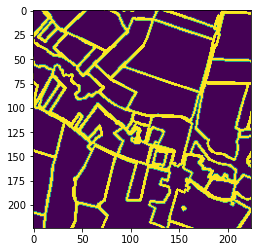

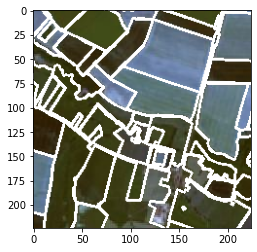

86254.0


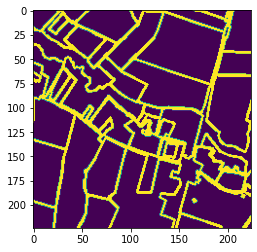

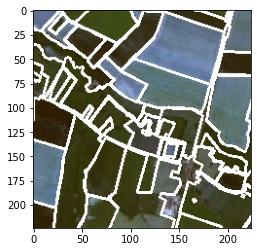

86253.0


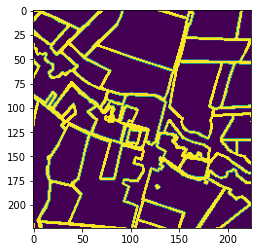

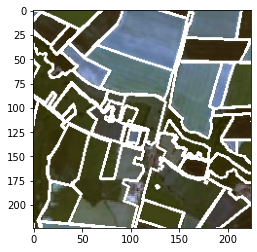

86246.0


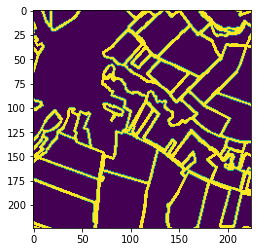

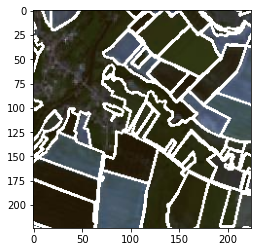

In [42]:
for json_file in json_folder:
    with open(json_file) as f:
      shp_dict = json.load(f)
      num_json_files_parsed += 1

    parcels_dict = create_dict_parcels(grid, shp_dict)
#     print(parcels_dict)
    for index in range(len(grid.keys())):
      image_id = grid[index]['Image_id']
#       print(image_id)
      polys = []
      if image_id in parcels_dict:
          for sh_index, sh in enumerate(parcels_dict[image_id]):
              count_parcels[image_id] += 1 
              for coord_idx in range(len(sh['geometry']['coordinates'])):
                  geom = np.array(sh['geometry']['coordinates'][coord_idx])
                  is_in_bounds, geom_fixed = scale_coords(shape_size, geom, grid, index)
                  pts = geom_fixed.astype(int)
                  polys.append(pts)
#       for sh_index, sh in enumerate(shp_dict['features']):
#         for coord_idx in range(len(sh['geometry']['coordinates'])):
#           geom = np.array(sh['geometry']['coordinates'][coord_idx])
#           is_in_bounds, geom_fixed = scale_coords(shape_size, geom, grid, index)
#           pts = geom_fixed.astype(int)
#           polys.append(pts)
#           print('parcel id', count_parcels[image_id])
          #Creates the binary mask
          print(image_id)
          mask_path = base_dir + 'masks/image_binary_' + str(int(image_id)) + '.png'
          mask_line = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
          cv2.polylines(mask_line, polys, True, color=255,thickness=2)
          #Saves the binary mask file
#           gray_mask = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
          cv2.imwrite(mask_path, mask_line)
          plt.imshow(mask_line)
          plt.show()

          #Saves the binary mask filled file
          mask_filled_path = base_dir + 'masks_filled/image_filled_binary_' + str(int(image_id)) + '.png'
          mask_filled = cv2.imread(mask_filled_path, cv2.IMREAD_UNCHANGED)
          cv2.fillPoly(mask_filled, polys, color=255)
          cv2.polylines(mask_filled, polys, True, color=0,thickness=2)
#           gray_mask = cv2.cvtColor(mask_filled, cv2.COLOR_BGR2GRAY)
          cv2.imwrite(mask_filled_path, mask_filled)

          #Saves the overlay file
          overlay_path = base_dir + 'overlay/image_overlay_' + str(int(image_id)) + '.jpeg'
          im_name = base_dir + orig_images_dir + str(int(image_id)) +'.jpeg'
          orig_image = cv2.imread(overlay_path)
          cv2.polylines(orig_image, polys, True, color=(255,255,255),thickness=2)
          cv2.imwrite(overlay_path, orig_image)
          plt.imshow(orig_image)
          plt.show()


86255.0


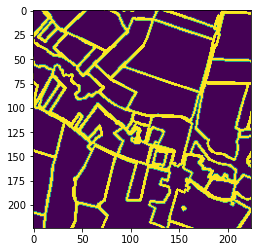

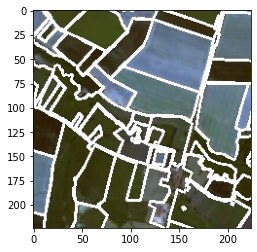

86254.0


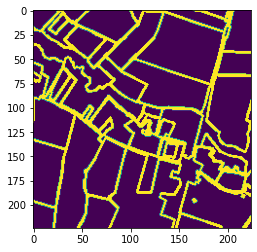

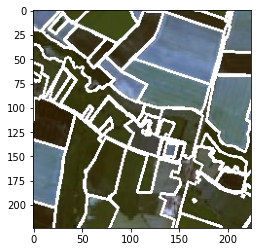

86253.0


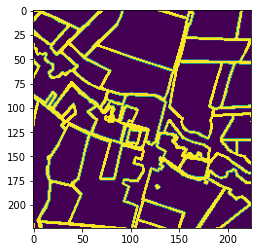

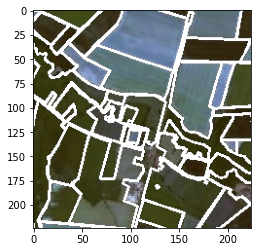

86246.0


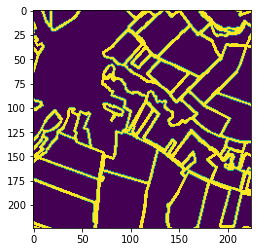

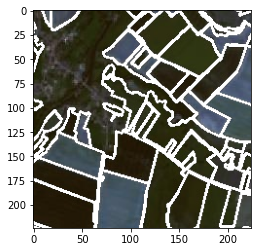

In [43]:
for json_file in json_folder:
    with open(json_file) as f:
      shp_dict = json.load(f)
      num_json_files_parsed += 1

    parcels_dict = create_dict_parcels(grid, shp_dict)
#     print(parcels_dict)
    for index in range(len(grid.keys())):
      image_id = grid[index]['Image_id']
#       print(image_id)
      polys = []
      if image_id in parcels_dict:
          for sh_index, sh in enumerate(parcels_dict[image_id]):
              count_parcels[image_id] += 1 
              for coord_idx in range(len(sh['geometry']['coordinates'])):
                  geom = np.array(sh['geometry']['coordinates'][coord_idx])
                  is_in_bounds, geom_fixed = scale_coords(shape_size, geom, grid, index)
                  pts = geom_fixed.astype(int)
                  polys.append(pts)
#       for sh_index, sh in enumerate(shp_dict['features']):
#         for coord_idx in range(len(sh['geometry']['coordinates'])):
#           geom = np.array(sh['geometry']['coordinates'][coord_idx])
#           is_in_bounds, geom_fixed = scale_coords(shape_size, geom, grid, index)
#           pts = geom_fixed.astype(int)
#           polys.append(pts)
#           print('parcel id', count_parcels[image_id])
          #Creates the binary mask
          print(image_id)
          mask_path = base_dir + 'masks/image_binary_' + str(int(image_id)) + '.png'
          mask_line = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
          cv2.polylines(mask_line, polys, True, color=255,thickness=2)
          #Saves the binary mask file
#           gray_mask = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
          cv2.imwrite(mask_path, mask_line)
          plt.imshow(mask_line)
          plt.show()

          #Saves the binary mask filled file
          mask_filled_path = base_dir + 'masks_filled/image_filled_binary_' + str(int(image_id)) + '.png'
          mask_filled = cv2.imread(mask_filled_path, cv2.IMREAD_UNCHANGED)
          cv2.fillPoly(mask_filled, polys, color=255)
          cv2.polylines(mask_filled, polys, True, color=0,thickness=2)
#           gray_mask = cv2.cvtColor(mask_filled, cv2.COLOR_BGR2GRAY)
          cv2.imwrite(mask_filled_path, mask_filled)

          #Saves the overlay file
          overlay_path = base_dir + 'overlay/image_overlay_' + str(int(image_id)) + '.jpeg'
          im_name = base_dir + orig_images_dir + str(int(image_id)) +'.jpeg'
          orig_image = cv2.imread(overlay_path)
          cv2.polylines(orig_image, polys, True, color=(255,255,255),thickness=2)
          cv2.imwrite(overlay_path, orig_image)
          plt.imshow(orig_image)
          plt.show()


In [ ]:
mask_folder = [base_dir + 'masks/' + f for f in os.listdir(base_dir + 'masks/')]
for mask_path in mask_folder:
#Saves the overlay file
    im_name = base_dir + orig_images_dir + str(int(image_id)) +'.jpeg'
    orig_image = cv2.imread(im_name)
    overlay_path = base_dir + 'overlay/image_overlay_' + str(int(image_id)) + '.jpeg'
    cv2.imwrite(overlay_path, orig_image)

In [54]:
# print(count_parcels)
with open('data/testrtree.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_ID', 'count'])
    for key, value in count_parcels.items():
        writer.writerow([int(key), value])